<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/NLP/Text_classification/Prohibited_language_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prohibited Language classification

Classification of foul language task using Bag of Words embeddings, TF-IDF, word vectors


## Imports

In [1]:
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from nltk.tokenize import TweetTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.model_selection import train_test_split


In [2]:
%matplotlib inline

## Load dataset

In [3]:
%%capture
!wget https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/NLP/Text_classification/data/comments.tsv

In [4]:
data = pd.read_csv('comments.tsv', sep='\t')

## Some basic EDA

In [5]:
data.head()

,should_ban,comment_text
0,0,The picture on the article is not of the actor...
1,1,"Its madness. Shes of Chinese heritage, but JAP..."
2,1,Fuck You. Why don't you suck a turd out of my ...
3,1,God is dead\nI don't mean to startle anyone bu...
4,1,THIS USER IS A PLANT FROM BRUCE PERENS AND GRO...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   should_ban    1000 non-null   int64 
 1   comment_text  1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


<Axes: xlabel='should_ban', ylabel='count'>

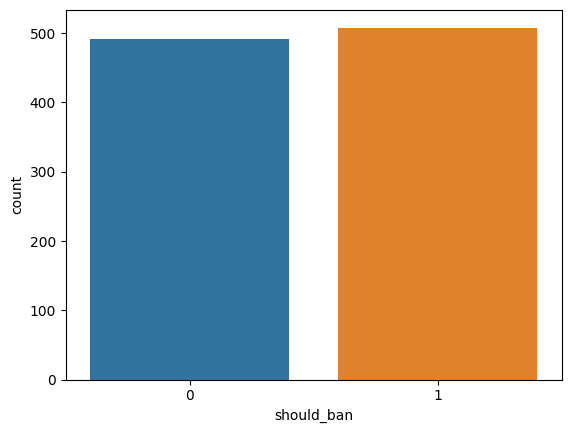

In [7]:
sns.countplot(data=data, x='should_ban')

In [8]:
data[data['comment_text'].str.len() <= 18]

,should_ban,comment_text
870,0,"No takers, then? ¦"


In [9]:
data[data['comment_text'].str.len() >=280]['comment_text'].count()

315

## Split data

In [10]:
X = data['comment_text'].values #data.drop('should_ban', axis=1)
y = data['should_ban'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

## Tokenize data

In [11]:
tokenizer = TweetTokenizer()
toker = lambda txt: ' '.join(tokenizer.tokenize(txt.lower()))
display(X_test[89])
toker(X_test[89])

'heY TOdds! Quick Q? \n\nWhy Are You So Gay'

'hey todds ! quick q ? why are you so gay'

In [12]:
v_tok = np.vectorize(toker)
texts_train = v_tok(X_train) #np.array([toker(x) for x in X_test])
texts_test = v_tok(X_test)

### Bathe in tests

In [13]:
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

## Baseline

In [14]:
tfidf = TfidfVectorizer(tokenizer=tokenizer.tokenize)
X_train_tfidf = tfidf.fit_transform(texts_train)
X_test_tfidf = tfidf.transform(texts_test)

rf = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_test_tfidf)

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 0.738
              precision    recall  f1-score   support

           0       0.70      0.77      0.73       231
           1       0.78      0.71      0.75       269

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.74      0.74      0.74       500



## Write word counter over all documents

In [63]:
def get_freq_words(documents: np.ndarray)-> dict:
  '''Counts the number of words in all documents. Returns a dict {word:number}'''
  frequent_words = {}
  for doc in documents:
    doc = doc.split()
    for word in doc:
      frequent_words[word] = frequent_words.get(word, 0) +1
  return frequent_words


def sort_freq_words(word_freq: dict, k: int)-> list:
  '''Returns a sorted by occurency list of words with most frequent being first'''
  return sorted(word_freq.items(), key=lambda items: items[1], reverse=True)[:k]

In [65]:
k = 10000
word_frequency = get_freq_words(texts_train)
sorted_words = sort_freq_words(word_frequency, k)
bow_vocabulary = [token for token, n in sorted_words]
bow_vocabulary[:10]

['.', ',', 'you', 'the', '"', 'a', 'to', 'i', 'and', '!']

## Create Bag of Words embeddings

In [83]:
def text_to_bow(text: str)-> np.ndarray:
    """Convert text string to an array of token counts. Use bow_vocabulary."""
    bow_vector = np.zeros(len(bow_vocabulary))
    for word in text.split():
        if word in bow_vocabulary:
            bow_vector[bow_vocabulary.index(word)] += 1
    return bow_vector

In [84]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

### Bathe in tests

In [86]:
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')